In [1]:
!pip install nltk

In [2]:
!pip install contractions

In [3]:
import nltk
nltk.download()
nltk.download('stopwords')  

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\babdulsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1.a Import Libraries

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plot
%matplotlib inline

# Seaborn
import seaborn as sns

from bs4 import BeautifulSoup
import re, string, unicodedata
import contractions
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords  
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import LabelEncoder

## 1.b Load dataset and print shape

In [5]:
#import the tweets csv file
tweets_df = pd.read_csv("Tweets.csv")

# Check the size of records
tweets_df.shape

(14640, 15)

## 1.c Description of data

In [6]:
# description of data
tweets_df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


### Analyse the data

In [7]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [8]:
# value counts
tweets_df.airline.value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

<AxesSubplot:xlabel='airline', ylabel='count'>

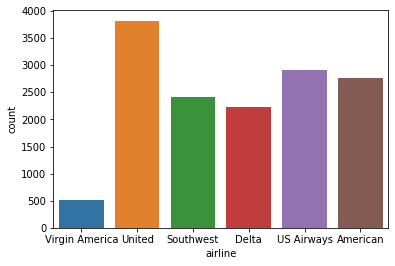

In [9]:
sns.countplot(x='airline',data=tweets_df)

In [10]:
# Sentiment count and plot
tweets_df.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

<AxesSubplot:xlabel='airline_sentiment', ylabel='count'>

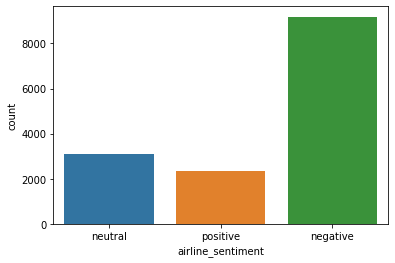

In [11]:
sns.countplot(x='airline_sentiment',data=tweets_df)

### 2.a Drop all the columns except sentiment and text

In [12]:
pd.set_option("max_colwidth", 250)
tweets_df = tweets_df.loc[ :,['airline_sentiment','text']]


### 2.b Check Shape of the data

In [13]:
tweets_df.shape

(14640, 2)

### 2.c Print first 5 rows

In [14]:
tweets_df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


### 3. Functions to do the text pre-processing

#### 3.a) HTML Tag removal

In [15]:
# Function to remove html tags
def Remove_Html_Tags(text):
    bsoup = BeautifulSoup(text,"html.parser")
    return bsoup.get_text()

#### 3.b) Tokenize

In [16]:
# Tokenize the sentence
import nltk
def Tokenize_Sentence(text):
    return nltk.word_tokenize(text)

#### 3.c) Number removal

In [17]:
# Function to remove the numbers
def Remove_Numbers(text):
    text = re.sub(r'\d+','', text)
    return text

#### 3.d) Remove special characters and punctuations

In [18]:
# Function to remove the contractions
def Replace_contractions(text):
        return(contractions.fix(text))

In [19]:
# Function to remove special characters
def Remove_SpecialChars(text):
    words = re.sub(r'[^a-zA-Z0-9_\s]+', '', text)
    return words

In [20]:
# Function to remove special characters
def Remove_nonascii_Chars(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words
    

In [21]:
# Function to remove the punctuations
def Remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

#### 3.e) Convert to lower case

In [22]:
# Function to convert to lowercase
def Convert_to_lowercase(words):
    new_words = []
    for word in words:
        newword = word.lower()
        new_words.append(newword)
    return new_words


#### 3.f) Lemmatize

In [23]:
# Lemmatize the given wors
def Lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []                           
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)             
    return lemmas

In [24]:
# Remove stop words
stopwords = stopwords.words('english')
def Remove_Stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

###  Normalize the words by doing all preprocessing

In [25]:
def Normalize_words(words):       
    #1. Replance non-ascii chars
    words = Remove_nonascii_Chars(words)    
   
    #2. Remove punctuations
    words = Remove_punctuation(words)
    
    #3. convert to lowercase
    words = Convert_to_lowercase(words)
    
    #4. Remove stop words
    words = Remove_Stopwords(words)
    
    #5. lemmataize words
    words = Lemmatize_words(words)
    
    return ' '.join(words)


### Preprocess the sentences

In [26]:
def SentenceLevel_PreProcessing(text):
    text   = Remove_Html_Tags(text)
    text   = Replace_contractions(text)
    text   = Remove_SpecialChars(text)
    text   = Remove_Numbers(text)
    words  = Tokenize_Sentence(text)
    return words

In [27]:
tweets_df['text'] = tweets_df.apply(lambda row: SentenceLevel_PreProcessing(row['text']), axis=1) # Tokenization of data
tweets_df['text'] = tweets_df.apply(lambda row: Normalize_words(row['text']), axis=1) # Tokenization of data
tweets_df.head(5)

,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience tacky
2,neutral,virginamerica today must mean need take another trip
3,negative,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,negative,virginamerica really big bad thing


### Do one hot encoding for the sentiment

In [28]:
labelencoder = LabelEncoder()
tweets_df["Sentiment"] = labelencoder.fit_transform(tweets_df['airline_sentiment'])
tweets_df

,airline_sentiment,text,Sentiment
0,neutral,virginamerica dhepburn say,1
1,positive,virginamerica plus add commercials experience tacky,2
2,neutral,virginamerica today must mean need take another trip,1
3,negative,virginamerica really aggressive blast obnoxious entertainment guests face little recourse,0
4,negative,virginamerica really big bad thing,0
...,...,...,...
14635,positive,americanair thank get different flight chicago,2
14636,negative,americanair leave minutes late flight warn communication minutes late flight call shitty customer svc,0
14637,neutral,americanair please bring american airlines blackberry,1
14638,negative,americanair money change flight answer phone suggestions make commitment,0


### 4.a) Count Vectorization

In [29]:
data_labels = tweets_df['Sentiment']

In [30]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()
data_features    = count_vectorizer.fit_transform(tweets_df['text'])
data_features    = data_features.toarray()

### Tfidf Vectorizer

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfid_vectorizer       = TfidfVectorizer()
tfid_data_features    = tfid_vectorizer.fit_transform(tweets_df['text'])
tfid_data_features    = tfid_data_features.toarray()
tfid_data_features.shape

(14640, 12606)

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

def Do_Classification(dataFeatures,dataLabels,method):
    print("----------------------------------------------------------------------------")
    print("                            ",method,"                                      ");
    print("----------------------------------------------------------------------------")
    
    # Split the data
    xTrain,xTest,yTrain,yTest = train_test_split(dataFeatures, dataLabels, test_size=0.3, random_state=10)
    
    # Create random forest classifer and fit the training data
    randForest = RandomForestClassifier(n_estimators=25, n_jobs=4)
    randForest = randForest.fit(xTrain, yTrain)
    
    # Get the cross validation score
    print("Cross val score =  " , np.mean(cross_val_score(randForest, dataFeatures, dataLabels, cv=10))) 
    
    # Predict the sentiment
    predLabels = randForest.predict(xTest)
    
    # Get the accuracy score
    acc = metrics.accuracy_score(yTest,predLabels)
    print("Accuracy = " , acc)
    
    # Classification report
    print(classification_report(yTest,predLabels))
    
    # Get the confusion matrix
    confMtx    = confusion_matrix(yTest,predLabels)
    
    print("Confusion Matrix")    
    print(confMtx)
    
    # Plot the confusion matrix
    plot.figure(figsize=(10,10))
    sns.heatmap(confMtx, annot=True,  fmt='.2f',  cmap="RdPu")    

## 5. Fit and evaluate models

----------------------------------------------------------------------------
                             Count Vectorizer                                       
----------------------------------------------------------------------------
Cross val score =   0.7221994535519125
Accuracy =  0.7431693989071039
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      2731
           1       0.58      0.44      0.50       958
           2       0.70      0.58      0.63       703

    accuracy                           0.74      4392
   macro avg       0.69      0.64      0.66      4392
weighted avg       0.73      0.74      0.73      4392

Confusion Matrix
[[2433  208   90]
 [ 448  421   89]
 [ 199   94  410]]


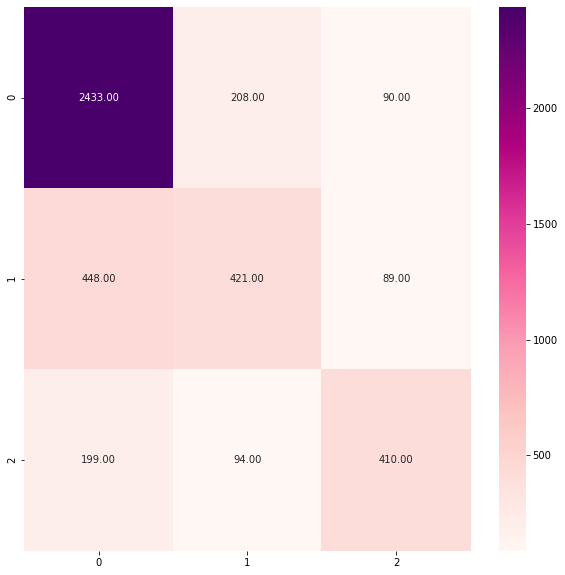

In [33]:
Do_Classification(data_features,data_labels,"Count Vectorizer")

----------------------------------------------------------------------------
                             Tf-Idf Vectorizer                                       
----------------------------------------------------------------------------
Cross val score =   0.7098360655737704
Accuracy =  0.7454462659380692
              precision    recall  f1-score   support

           0       0.76      0.95      0.84      2731
           1       0.64      0.34      0.44       958
           2       0.74      0.52      0.61       703

    accuracy                           0.75      4392
   macro avg       0.72      0.60      0.63      4392
weighted avg       0.73      0.75      0.72      4392

Confusion Matrix
[[2582   93   56]
 [ 562  326   70]
 [ 247   90  366]]


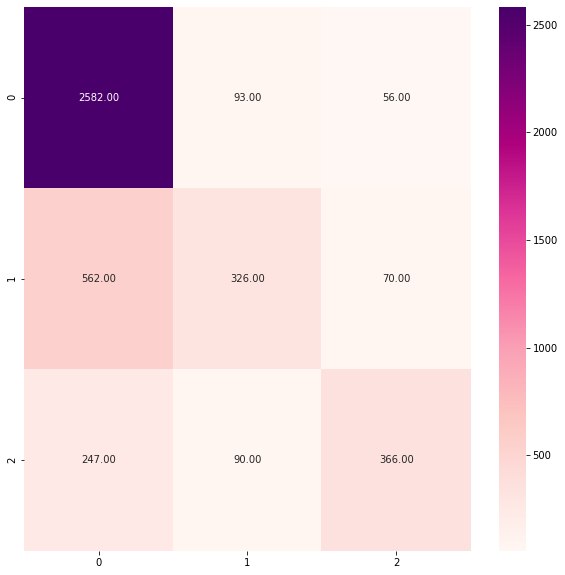

In [34]:
Do_Classification(tfid_data_features,data_labels,"Tf-Idf Vectorizer")

## Summary

#### 1. The text/document should be cleaned up with all the words which does not add any contextual value to it like the punctuations, special characters, special tags, frequently used stop words. Removing all of them and keeping only contextual information is essential to identify the sentiment/classifcation is done during preprocessing.

#### 2. Text preprocessing steps are 
            a) HTML Tags removal - Tags does not add any value to the document and hence can be removed
            b) Removing punctuations - Punctuation does not add sentimental values except at few scenarios.Hence removed.
            c) Removing contractions - This will help to reduce the dimensionality of the document matrix 
            d) Removing the numbers if it does not add any value ( some time we may need as feedback involves ratings like 9/10
            e) Remvoing the stopwords - Reduces the length of the documents
            f) Lemmatizing/Stemming the words which reduces the derivational and inflectional form to their base form.
            
#### 3. Once we have the clean text, we have to convert them into numbers before feeding them into models to classify. As models works only only on numbers , text input has to be converted into numbers using vectorization techniques. 

#### 4. Vectorization converts the corpus of text into matrix form. The columns are nothing but the unique words of the cleaned text and the value of matrix changes based on the vectorization method.

#### 5.  Count vectorization accounts or assigns equal weight to the words in the document and hence its biased in favor of frequently encountered words and the rare words are ignored.

#### 6. Tf-Idf vectorizer accounts the words across all the documents and helps us to deal with penalizing the most frequent words. Words are assigned with weights by counting their number of presence in the documents. Rare words are assigned with higher weightage and frequently used words are penalized with less weightage.

#### 7. With both the above vectorization methods, the model is performing well in identifying the negative comments compared to identifying the neutral and positive comments. 

#### 8. There are more negative tweets than the positive and neutral.

#### 9. Accuracy value of count vectorizer is better than  Tf-idf vectorizer .

#### 10. Prediction of negative feedback is important here so that airlines can address the issues and improve the customer experience. Tf-idf vectorizer performs better recall values of negative feedback.